# Capstone Project - Battle of the Cities
### IBM's Applied Data Science Capstone online course via Coursera

## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [Acknowledgements](#acknowledgements)



## Introduction <a name="introduction"></a>

This project focuses on ideal cities to call home. Targeted specifically for upcoming data scientists who earned the IBM Data Science Professional Certificate, and are now interested in a career at **IBM's headquarters** in **Armonk, NY**.

To ease the commute, only cities within a **reasonable distance** of IBM's HQ will be considered. **Local venues and venue types** will then be examined and used to recommend cities based on **lifestyle preferences**.

Utilizing data science, cities grouped by similar types and amounts of venues will be plotted and analyzed. Recommendations will be given based on inferred lifestyle preferences of the grouped cities so that new employees of IBM's HQ may more readily decide their ideal city to call home.

## Data <a name="data"></a>

Variables of influence:
* cities close enough to IBM's HQ
* amount and type of city venues
* clustering of cities

For the sake of this project, a reasonable commute distance is defined as within a 35-mile drive from IBM's HQ. (Was originally set to 50 miles, but deemed too broad a scope - see note below.)

* ###### This change was made in assistance with GoogleMaps. A handful of cities at 5km intervals (starting at 80km and going down) were each used in the "To" section of GoogleMaps with the address of IBM's headquarters in the "From" section. The depart time was set to 6am on Wednesday, October 2, 2019 and the goal for a reasonable commute was to consistently have 1hr or less for the lower end of the expected travel-time range. If cities were typically not within the 1hr commute, then the next lowest 5km cities were evaluated. This continued until the cities within 60km were reached and met the specified criteria. For convenience sake, this was converted to 35mi and only cities within a 35mi radius from IBM's headquarters were included in this project.

Some cities had too few venues, in comparison to others. Their coordinates were re-examined and tweaked as necessary for more accurate positioning and additional results.

Clustering was done via k-Means. After attempting multiple methods to find the optimal k, ended up using the elbow method because of its' simplicity and widespread use.


How data sources were utilized:
* cities nearby IBM's HQ determined with **FreeMapTools**' free tool to find zip codes (along with cities and their distance) within a specified radius
* cities filtered by population criteria with the **BeautifulSoup** package and **Wikipedia** pages listing state towns and/or cities
* coordinates of cities retrieved via the **geocoder package using ArcGIS** data
* amount and type of city venues retrieved via **Foursquare's API**

#### Determine commutable distance

To determine which cities were close to IBM's headquarters, FreeMapTools' free tool to find zip codes within a specified radius was utilized. Not only did it return zip codes, but a list of cities as well as cities **combined** with their distance from IBM's headquarters. Using the latitude and longitude coordinates of the headquarters (41.108329, -73.720467), a radius of 50mi was originally specified. But it was deemed unhelpful for the scope of this project, and changed to a more reasonable commute of 35mi instead. The data returned within the **combined** section was saved as a CSV file titled "cities_near_IBM_HQ.csv", and this file was then created as a dataframe via pandas' read_csv command.

A link to the tool from FreeMapTools is below:  
https://www.freemaptools.com/find-zip-codes-inside-radius.htm

So far, this data only provides a list of cities within a commutable distance. To determine nearby venues and then venue types of each city, Foursquare's location data will be of assistance. Just a few examples of venue types are "Coffee Shop", "Hotel", and "Park". This information will be retrieved via code in Python, using the user's Foursquare credentials. Then ultimately, all of this data will be used to offer recommendations on which cities individuals would like to live.

#### Nearby Cities

Setting up the dataframe for nearby_cities.

In [1]:
# install and import necessary packages
!pip install beautifulsoup4 # install the BeautifulSoup library for web scraping
!pip install lxml # install lxml parser to break down the html page into parts
!pip install requests # install the requests library
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
print('...Packages installed!')

     |████████████████████████████████| 102kB 14.3MB/s ta 0:00:01
     |████████████████████████████████| 5.8MB 32.4MB/s eta 0:00:01
...Packages installed!


In [2]:
pd.reset_option('display.max_rows')

In [3]:
# create a pandas dataframe from a csv_file of cities within a 35-mile commute of IBM's HQ
nearby_cities = pd.read_csv('cities_near_IBM_HQ.csv', header=None)

# rename column headers
labels = ['ZIP', 'State', 'County', 'City', 'TimeZone', 'Distance(km)']
nearby_cities.columns = labels

# drop unnecessary columns
columns = ['ZIP', 'TimeZone', 'Distance(km)']
nearby_cities.drop(columns, axis=1, inplace=True)

# re-arrange column order
nearby_cities = nearby_cities[['City', 'State', 'County']]

# remove duplicate rows with the same city-state combination
## because the data includes ZIP codes with some duplicate city-states
nearby_cities = nearby_cities.drop_duplicates(subset=['City', 'State'])

# sort the City, State column in descending order
nearby_cities = nearby_cities.sort_values(by='City', ascending=True)

# reset index
nearby_cities = nearby_cities.reset_index(drop=True) # drops the previous index column
nearby_cities

,City,State,County
0,Albertson,NY,Nassau
1,Allendale,NJ,Bergen
2,Alpine,NJ,Bergen
3,Amawalk,NY,Westchester
4,Amityville,NY,Suffolk
...,...,...,...
393,Woodside,NY,Queens
394,Wyandanch,NY,Suffolk
395,Wyckoff,NJ,Bergen
396,Yonkers,NY,Westchester


This dataframe only includes locations within a 35-mile drive of IBM's headquarters.

This dataframe presumably also includes only cities, but for this project, the definition of a "city" has not yet been clarified. For this project, a city is any location with a population of 20,000 or greater as of 2010. Since the above dataframe does not include population data, another outside source will be used, and then merged with the above dataframe.

#### New York Cities' Populations

Retrieving population data of NY cities.

In [4]:
# pull code from the web via the requests library
source = requests.get('https://en.wikipedia.org/wiki/List_of_towns_in_New_York_(state)').text

# use BeautifulSoup to scrape and lxml to parse
soup = BeautifulSoup(source, 'lxml')

# retrieve only the text within the <table> tag, then read the data into a pandas dataframe
table = soup.find_all('table')[1] # [1] is an index value - retrieves only the second table from the webpage
ny_city_pops = pd.read_html(str(table))[0] # [0] converts data from a list to a dataframe, remove it to see!

# rewrite ny_city_pops with only desired columns
ny_city_pops = ny_city_pops[['Town', 'County', 'Pop.(2010)']]

# rename column headers
labels = ['City', 'County', 'Pop2010']
ny_city_pops.columns = labels

# add Armonk, NY to ny_city_pops (not included in Wikipedia's table)
ny_city_pops = ny_city_pops.append({'City':'Armonk', 'County':'Westchester', 'Pop2010':4330}, ignore_index=True)
ny_city_pops.tail()

,City,County,Pop2010
929,Yates,Orleans,2559
930,York,Livingston,3397
931,Yorkshire,Cattaraugus,3913
932,Yorktown,Westchester,36081
933,Armonk,Westchester,4330


#### Connecticut Cities' Populations

Retrieving population data of CT cities.

In [5]:
# pull code from the web via the requests library
source = requests.get('https://en.wikipedia.org/wiki/List_of_towns_in_Connecticut').text

# use BeautifulSoup to scrape and lxml to parse
soup = BeautifulSoup(source, 'lxml')

# retrieve only the text within the <table> tag, then read the data into a pandas dataframe
table = soup.find_all('table')[1]
ct_city_pops = pd.read_html(str(table))[0] # [0] converts data from a list to a dataframe, remove it to see!

# rewrite ct_city_pops with only desired columns
ct_city_pops = ct_city_pops[['Town', 'County', 'Population(in 2010)']]

# rename column headers
labels = ['City', 'County', 'Pop2010']
ct_city_pops.columns = labels

# remove NaN row (removes the Totals row at the bottom)
ct_city_pops.dropna(axis=0, inplace=True)
ct_city_pops

,City,County,Pop2010
0,Andover,Tolland County,3303
1,Ansonia,New Haven County,19249
2,Ashford,Windham County,4100
3,Avon,Hartford County,18098
4,Barkhamsted,Litchfield County,3620
...,...,...,...
164,Windsor Locks,Hartford County,12498
165,Wolcott,New Haven County,16680
166,Woodbridge,New Haven County,8990
167,Woodbury,Litchfield County,9975


#### New Jersey Cities' Populations

Retrieving population data of NJ cities.

In [6]:
# pull code from the web via the requests library
source = requests.get('https://en.wikipedia.org/wiki/List_of_municipalities_in_New_Jersey').text

# use BeautifulSoup to scrape and lxml to parse
soup = BeautifulSoup(source, 'lxml')

# retrieve only the text within the <table> tag, then read the data into a pandas dataframe
table = soup.find_all('table')[0] # use [0] because on this webpage the table appears first
nj_city_pops = pd.read_html(str(table))[0] # [0] converts data from a list to a dataframe, remove it to see!

# rewrite nj_city_pops with only desired columns
nj_city_pops = nj_city_pops[['Municipality', 'County', 'Population in 2010']]

# rename column headers
labels = ['City', 'County', 'Pop2010']
nj_city_pops.columns = labels
nj_city_pops

,City,County,Pop2010
0,Newark,Essex,277140
1,Jersey City,Hudson,247597
2,Paterson,Passaic,146199
3,Elizabeth,Union,124969
4,Edison,Middlesex,99967
...,...,...,...
560,Loch Arbour,Monmouth,194
561,Teterboro,Bergen,67
562,Walpack Township,Sussex,16
563,Pine Valley,Camden,12


---

#### New York Nearby & Highpop

Merge nearby_cities with ny_city_pops (so that NY cities not within the 35-mile commute range can be removed).

In [7]:
# perform an outer merge of nearby_cities and ny_city_pops on the City column
ny_merge = pd.merge(nearby_cities, ny_city_pops, on='City', how='outer')

# drop rows that contain NaN
ny_merge.dropna(axis=0, inplace=True)

# remove rows not of NY state data
ny_merge = ny_merge[ny_merge.State == 'NY']

# sort by Pop2010
ny_merge = ny_merge.sort_values(by='Pop2010', ascending=False)

# reset index
ny_merge = ny_merge.reset_index(drop=True) # drops the previous index column

Filter so only nearby NY cities with a population of over 20,000 (as of 2010) are included.

In [8]:
# create a new df of only rows with 20000 or greater population and the row with Armonk's data
ny_nearby_highpop = ny_merge.loc[(ny_merge['Pop2010'] >= 20000) | (ny_merge['City'] == 'Armonk')] # | = or ; & = and
ny_nearby_highpop

,City,State,County_x,County_y,Pop2010
0,Hempstead,NY,Nassau,Nassau,759757.0
1,Oyster Bay,NY,Nassau,Nassau,293214.0
2,Huntington,NY,Suffolk,Suffolk,203264.0
3,Smithtown,NY,Suffolk,Suffolk,117801.0
4,Rye,NY,Westchester,Westchester,45928.0
5,Monroe,NY,Orange,Orange,39912.0
6,Ossining,NY,Westchester,Westchester,37674.0
7,Haverstraw,NY,Rockland,Rockland,36634.0
8,Carmel,NY,Putnam,Putnam,34305.0
9,Eastchester,NY,Westchester,Westchester,32363.0


#### Connecticut Nearby & Highpop

Merge nearby_cities with ct_city_pops (so that CT cities not within the 35-mile commute range can be removed).

In [9]:
# perform an outer merge of nearby_cities and ct_city_pops on the City column
ct_merge = pd.merge(nearby_cities, ct_city_pops, on='City', how='outer')

# drop rows that contain NaN
ct_merge.dropna(axis=0, inplace=True)

# remove rows not of CT state data
ct_merge = ct_merge[ct_merge.State == 'CT']

# sort by Pop2010
ct_merge = ct_merge.sort_values(by='Pop2010', ascending=False)

# reset index
ct_merge = ct_merge.reset_index(drop=True) # drops the previous index column

Filter so only nearby CT cities with a population of over 20,000 (as of 2010) are included.

In [10]:
# create a new df of only rows with 20000 or greater population
ct_nearby_highpop = ct_merge.loc[ct_merge['Pop2010'] >= 20000]
ct_nearby_highpop

,City,State,County_x,County_y,Pop2010
0,Bridgeport,CT,Fairfield,Fairfield County,144229.0
1,Stamford,CT,Fairfield,Fairfield County,122643.0
2,Norwalk,CT,Fairfield,Fairfield County,85603.0
3,Danbury,CT,Fairfield,Fairfield County,80893.0
4,Greenwich,CT,Fairfield,Fairfield County,61171.0
5,Fairfield,CT,Fairfield,Fairfield County,59404.0
6,Stratford,CT,Fairfield,Fairfield County,51384.0
7,Shelton,CT,Fairfield,Fairfield County,39559.0
8,Trumbull,CT,Fairfield,Fairfield County,36018.0
9,Newtown,CT,Fairfield,Fairfield County,27560.0


#### New Jersey Nearby & Highpop

Merge nearby_cities with nj_city_pops (so that NJ cities not within the 35-mile commute range can be removed).

In [11]:
# perform an outer merge of nearby_cities and nj_city_pops on the City column
nj_merge = pd.merge(nearby_cities, nj_city_pops, on='City', how='outer')

# drop rows that contain NaN
nj_merge.dropna(axis=0, inplace=True)

# remove rows not of NJ state data
nj_merge = nj_merge[nj_merge.State == 'NJ']

# sort by Pop2010
nj_merge = nj_merge.sort_values(by='Pop2010', ascending=False)

# reset index
nj_merge = nj_merge.reset_index(drop=True) # drops the previous index column

Filter so only nearby NJ cities with a population of over 20,000 (as of 2010) are included.

In [12]:
# create a new df of only rows with 20000 or greater population
nj_nearby_highpop = nj_merge.loc[nj_merge['Pop2010'] >= 20000]
nj_nearby_highpop

,City,State,County_x,County_y,Pop2010
0,Newark,NJ,Essex,Essex,277140.0
1,Jersey City,NJ,Hudson,Hudson,247597.0
2,Paterson,NJ,Passaic,Passaic,146199.0
3,Clifton,NJ,Passaic,Passaic,84136.0
4,Passaic,NJ,Passaic,Passaic,69781.0
5,Union City,NJ,Hudson,Hudson,66455.0
6,East Orange,NJ,Essex,Essex,64270.0
7,North Bergen,NJ,Hudson,Hudson,60773.0
8,Wayne,NJ,Passaic,Passaic,54717.0
9,Hoboken,NJ,Hudson,Hudson,50005.0


Now create a new dataframe that joins all 3 highpop dataframes together (so the data of cities within all 3 states is in one place).

#### All Nearby & Highpop

In [13]:
# join 3 state nearby and highpop dfs together to create a dataframe of all nearby and highpop cities
all_nearby_highpop = pd.concat([ny_nearby_highpop, ct_nearby_highpop, nj_nearby_highpop])
all_nearby_highpop

,City,State,County_x,County_y,Pop2010
0,Hempstead,NY,Nassau,Nassau,759757.0
1,Oyster Bay,NY,Nassau,Nassau,293214.0
2,Huntington,NY,Suffolk,Suffolk,203264.0
3,Smithtown,NY,Suffolk,Suffolk,117801.0
4,Rye,NY,Westchester,Westchester,45928.0
5,Monroe,NY,Orange,Orange,39912.0
6,Ossining,NY,Westchester,Westchester,37674.0
7,Haverstraw,NY,Rockland,Rockland,36634.0
8,Carmel,NY,Putnam,Putnam,34305.0
9,Eastchester,NY,Westchester,Westchester,32363.0


In [14]:
# reset index
all_nearby_highpop = all_nearby_highpop.reset_index(drop=True) # drops the previous index column
all_nearby_highpop.shape

(60, 5)

So, 60 total cities have a population of 20,000 or greater (as of 2010) and are within a 35-mile commute of IBM's headquarters.

---

#### City Coordinate Retrieval

Now prepare for retrieving coordinates of each of the cities.

In [15]:
# create a new column called City, State (makes it easier to find coordinates)
all_nearby_highpop['City, State'] = all_nearby_highpop[['City', 'State']].apply(', '.join, axis=1)

# remove original City and State columns
columns = ['City', 'State']
all_nearby_highpop.drop(columns, axis=1, inplace=True)

# sort the City, State column in descending order
all_nearby_highpop = all_nearby_highpop.sort_values(by='City, State', ascending=True)

# reset index
all_nearby_highpop = all_nearby_highpop.reset_index(drop=True) # drops the previous index column
all_nearby_highpop.head()

,County_x,County_y,Pop2010,"City, State"
0,Westchester,Westchester,4330.0,"Armonk, NY"
1,Essex,Essex,35926.0,"Belleville, NJ"
2,Bergen,Bergen,26652.0,"Bergenfield, NJ"
3,Essex,Essex,47315.0,"Bloomfield, NJ"
4,Fairfield,Fairfield County,144229.0,"Bridgeport, CT"


In [16]:
#install geocoder package for retrieving lat and long coordinates
!pip install geocoder
print('... geocoder installed!')

import geocoder

     |████████████████████████████████| 102kB 18.6MB/s ta 0:00:01
     |████████████████████████████████| 829kB 35.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 20.0MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
... geocoder installed!


In [17]:
latitude = [] # brackets represent a blank list (will put result into these)
longitude = []

# create a for loop to retrieve coordinates for each City, State
for place in all_nearby_highpop['City, State']:
    g = geocoder.arcgis('{}'.format(place))
    lat_lng_coords = g.latlng
    print(place, lat_lng_coords) # commenting out so won't see long wall of code on GitHub - uncomment to ensure correct results
    
    latitude.append(lat_lng_coords[0]) # use append and [0] to add first index of lat_lng_coords to the latitude variable
    longitude.append(lat_lng_coords[1])
    
## wait about a minute for the loop to cycle through
## potential error: connection may time out; if so, run cell again and wait

Armonk, NY [41.12188000000003, -73.70869999999996]
Belleville, NJ [40.79546000000005, -74.14924999999994]
Bergenfield, NJ [40.93480000000005, -73.99546999999995]
Bloomfield, NJ [40.79191000000003, -74.19574999999998]
Bridgeport, CT [41.18213000000003, -73.19063999999997]
Carmel, NY [41.42798000000005, -73.67673999999994]
Cliffside Park, NJ [40.82125000000008, -73.98799999999994]
Clifton, NJ [40.86575000000005, -74.15981999999997]
Danbury, CT [41.39268000000004, -73.45358999999996]
Darien, CT [41.06908000000004, -73.47752999999994]
East Orange, NJ [40.76099000000005, -74.20990999999998]
Eastchester, NY [40.95633000000004, -73.81517999999994]
Englewood, NJ [40.89525000000003, -73.97459999999995]
Fair Lawn, NJ [40.93610000000007, -74.13190999999995]
Fairfield, CT [41.16633000000007, -73.22875999999997]
Fishkill, NY [41.535330000000044, -73.90290999999996]
Fort Lee, NJ [40.85339000000005, -73.97427999999996]
Garfield, NJ [40.88137000000006, -74.11343999999997]
Greenwich, CT [41.06425000000

In [18]:
# add a Latitude and Longitude column to the dataframe - populate with latitude and longitude lists
all_nearby_highpop['Latitude'] = latitude
all_nearby_highpop['Longitude'] = longitude
all_nearby_highpop.head()

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
0,Westchester,Westchester,4330.0,"Armonk, NY",41.12188,-73.70870
1,Essex,Essex,35926.0,"Belleville, NJ",40.79546,-74.14925
2,Bergen,Bergen,26652.0,"Bergenfield, NJ",40.93480,-73.99547
3,Essex,Essex,47315.0,"Bloomfield, NJ",40.79191,-74.19575
4,Fairfield,Fairfield County,144229.0,"Bridgeport, CT",41.18213,-73.19064


#### Map All Nearby & Highpop Cities

Create a map displaying the locations of each of the cities.

In [80]:
import folium # map rendering library

# create a map of Armonk using IBM's HQ coordinates
map_armonk = folium.Map(location=[41.108329, -73.720467], zoom_start=9)

# add city, state markers
for lat, lng, place in zip(all_nearby_highpop['Latitude'], all_nearby_highpop['Longitude'], all_nearby_highpop['City, State']):
    label = '{}'.format(place)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_armonk)  
    
map_armonk

## Foursquare

Use Foursquare to retrieve nearby venue data of all nearby, highpop cities (so can better recommend where to live based on venues nearby).

In [20]:
# write down your Foursquare credentials and version
CLIENT_ID = 'OTTSMWX5Y1XYDLR3OWHUWVEVDTH1HO3N2BKCTJD4JMGNZYIH' # your Foursquare ID
CLIENT_SECRET = 'TTST1GFSD4HKPE4VQAWJB3YVLDGZ2VIZTBI03BZQTXFI5FYA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: OTTSMWX5Y1XYDLR3OWHUWVEVDTH1HO3N2BKCTJD4JMGNZYIH
CLIENT_SECRET:TTST1GFSD4HKPE4VQAWJB3YVLDGZ2VIZTBI03BZQTXFI5FYA


In [21]:
LIMIT = 100 # limits number of returned venues

pd.set_option('display.max_rows', None)

Create the user-defined function getNearbyVenues.

In [22]:
# will return up to 100 venues within half a mile of each city
def getNearbyVenues(names, latitudes, longitudes, radius=805): #805m = ~half a mile
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [81]:
# create a new dataframe of venues close to all nearby highpop cities
## (will print only city names when applying the function)
armonk_venues = getNearbyVenues(names = all_nearby_highpop['City, State'],
                                   latitudes = all_nearby_highpop['Latitude'],
                                   longitudes = all_nearby_highpop['Longitude']
                                  )

# wait about 30 seconds
# if an error appears about 'groups', re-run the cell

Armonk, NY
Belleville, NJ
Bergenfield, NJ
Bloomfield, NJ
Bridgeport, CT
Carmel, NY
Cliffside Park, NJ
Clifton, NJ
Danbury, CT
Darien, CT
East Orange, NJ
Eastchester, NY
Englewood, NJ
Fair Lawn, NJ
Fairfield, CT
Fishkill, NY
Fort Lee, NJ
Garfield, NJ
Greenwich, CT
Hackensack, NJ
Harrison, NY
Haverstraw, NY
Hempstead, NY
Hoboken, NJ
Huntington, NY
Jersey City, NJ
Kearny, NJ
Lodi, NJ
Lyndhurst, NJ
Mahwah, NJ
Mamaroneck, NY
Monroe, NY
Montclair, NJ
New Windsor, NY
Newark, NJ
Newburgh, NY
Newtown, CT
North Bergen, NJ
Norwalk, CT
Nutley, NJ
Ossining, NY
Oyster Bay, NY
Paramus, NJ
Passaic, NJ
Paterson, NJ
Ridgefield, CT
Ridgewood, NJ
Rye, NY
Shelton, CT
Smithtown, NY
Somers, NY
Stamford, CT
Stratford, CT
Teaneck, NJ
Trumbull, CT
Union City, NJ
Wayne, NJ
West Milford, NJ
West New York, NJ
Westport, CT


In [24]:
armonk_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Armonk, NY",41.12188,-73.7087,Equinox Armonk,41.120953,-73.708910,Gym
1,"Armonk, NY",41.12188,-73.7087,DeCicco & Sons,41.126228,-73.712832,Supermarket
2,"Armonk, NY",41.12188,-73.7087,Fortina,41.126450,-73.712623,Italian Restaurant
3,"Armonk, NY",41.12188,-73.7087,DeCicco's Pub,41.126124,-73.712678,Pub
4,"Armonk, NY",41.12188,-73.7087,Amore Pizzeria & Pasta,41.124916,-73.714917,Italian Restaurant


Create a *armonk_onehot* dataframe to show the distribution of each venue category type. (With 1 meaning applicable, and 0 meaning not applicable.)

In [82]:
pd.set_option('display.max_columns', None) # so can see all of the columns (otherwise will see ... in the middle)

## create a new dataframe of dummy variables to see the venue category of venue near each city
# perform one hot encoding
armonk_onehot = pd.get_dummies(armonk_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
armonk_onehot['City'] = armonk_venues['City']

# move city column to the beginning
col_at_beg = ['City']
armonk_onehot = armonk_onehot[[i for i in col_at_beg] 
        + [i for i in armonk_onehot if i not in col_at_beg]] 

armonk_onehot.head(10)

,City,Accessories Store,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Road,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game St

In [83]:
armonk_onehot.shape

(2848, 283)

Now group by city and visualize the mean frequency per appearance of each venue category type.

In [84]:
# use groupby to combine venues' data within the same city into one row each
# and show the mean frequency of venue category of venues within each city
armonk_mean_freq = armonk_onehot.groupby('City').mean().reset_index()
armonk_mean_freq.head(5)

,City,Accessories Store,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Road,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game St

In [85]:
armonk_mean_freq.shape

(60, 283)

Determine the most-frequent venue categories per city and put this into a city_venues_sorted dataframe.

In [86]:
# determine the 5 most-frequent venue category types nearby each city
num_top_venues = 5

for place in armonk_mean_freq['City']:
    print("----"+place+"----")
    
    temp = armonk_mean_freq[armonk_mean_freq['City'] == place].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n') # adds a blank line separating each city temp table

----Armonk, NY----
                     venue  freq
0                     Park  0.06
1      American Restaurant  0.06
2       Italian Restaurant  0.06
3        Recreation Center  0.03
4  New American Restaurant  0.03


----Belleville, NJ----
                venue  freq
0         Pizza Place  0.14
1  Italian Restaurant  0.07
2   Martial Arts Dojo  0.05
3            Pharmacy  0.05
4   Convenience Store  0.05


----Bergenfield, NJ----
                venue  freq
0         Pizza Place  0.09
1  Italian Restaurant  0.06
2        Dance Studio  0.06
3      Sandwich Place  0.06
4                Bank  0.04


----Bloomfield, NJ----
         venue  freq
0  Gas Station  0.05
1         Bank  0.05
2        Diner  0.05
3   Donut Shop  0.05
4   Steakhouse  0.03


----Bridgeport, CT----
                venue  freq
0           Juice Bar  0.06
1          Donut Shop  0.06
2  Chinese Restaurant  0.04
3              Lawyer  0.04
4                Café  0.04


----Carmel, NY----
                venue  freq
0  

In [87]:
# create a user-defined function called return_most_common_venues
# will sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [88]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd'] # word part of 1st, 2nd, 3rd
columns = ['City']

# create columns according to number of top venues
# for loop where column number increases by one and suffixes added as st, nd, rd then only with th
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) 
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe with the 10 most frequent nearby venues by category for each city
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = armonk_mean_freq['City']

for ind in np.arange(armonk_mean_freq.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(armonk_mean_freq.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armonk, NY",American Restaurant,Park,Italian Restaurant,Indian Restaurant,Mexican Restaurant,Supermarket,Gastropub,Gas Station,Sporting Goods Shop,Spa
1,"Belleville, NJ",Pizza Place,Italian Restaurant,Sandwich Place,Martial Arts Dojo,Gym,Chinese Restaurant,Pharmacy,Convenience Store,Shopping Plaza,Clothing Store
2,"Bergenfield, NJ",Pizza Place,Italian Restaurant,Dance Studio,Sandwich Place,Bagel Shop,Fast Food Restaurant,Bar,BBQ Joint,Convenience Store,Pharmacy
3,"Bloomfield, NJ",Diner,Bank,Gas Station,Donut Shop,Ice Cream Shop,Shoe Store,Market,Steakhouse,Martial Arts Dojo,Southern / Soul Food Restaurant
4,"Bridgeport, CT",Donut Shop,Juice Bar,Lawyer,Italian Restaurant,Chinese Restaurant,Café,Spanish Restaurant,Concert Hall,Plaza,Latin American Restaurant


---

## Methodology <a name="methodology"></a>

This project focuses upon locating cities within a commutable distance of IBM's headquarters and with a sizable population; then it will group them by similar most common venues in the surrounding area.

For the first step, it was determined which cities were within a **reasonable 35-mile commute of IBM's headquarters**. These cities were then combined with cities of neighboring states consisting of a **20,000 or greater population (as of 2010)** so that these areas were both within an acceptable distance *and* large enough to be deemed "cities".

For the second step, **city coordinates were retrieved** via the geocoder package, and the city locations were mapped.

For the third step, Foursquare was utilized to retrieve the **100 most common nearby venue type data within a half mile of each city**.

For the fourth step, the **coordinates of cities with few nearby venues were altered**, then these cities were **re-mapped and re-ran through the Foursquare section of the report** to keep it up to date with the changes.

For the fifth step, k-Means was used to **cluster the cities together based on similar most common nearby venue types**, and the clusters were analyzed.

## Analysis <a name="analysis"></a>

### Exploratory Data Analysis

#### Investigate why certain cities appear multiple times in nearby_cities

This section refers to analysis of the original dataframe, since certain cities appeared multiple times.

In [32]:
# verify only 1 appearance of each city in the dataframe
vc = nearby_cities['City'].value_counts()
vc.head(10)

Hawthorne     2
Ridgewood     2
Monroe        2
Ridgefield    2
Fairfield     2
Harrison      2
Peekskill     1
Armonk        1
Trumbull      1
Cos Cob       1
Name: City, dtype: int64

In [33]:
# determine which cities appear twice
vc[vc>1]

Hawthorne     2
Ridgewood     2
Monroe        2
Ridgefield    2
Fairfield     2
Harrison      2
Name: City, dtype: int64

In [34]:
# examine rows with Fairfield as city 
nearby_cities[nearby_cities['City'].str.contains("Fairfield")]

,City,State,County
98,Fairfield,NJ,Essex
99,Fairfield,CT,Fairfield
226,New Fairfield,CT,Fairfield


In [35]:
# examine rows with Ridgefield as city 
nearby_cities[nearby_cities['City'].str.contains("Ridgefield")]

,City,State,County
287,Ridgefield,CT,Fairfield
288,Ridgefield,NJ,Bergen
289,Ridgefield Park,NJ,Bergen


In [36]:
# examine rows with Ridgewood as city 
nearby_cities[nearby_cities['City'].str.contains("Ridgewood")]

,City,State,County
290,Ridgewood,NY,Queens
291,Ridgewood,NJ,Bergen


In [37]:
# examine rows with Monroe as city 
nearby_cities[nearby_cities['City'].str.contains("Monroe")]

,City,State,County
213,Monroe,CT,Fairfield
214,Monroe,NY,Orange


In [38]:
# examine rows with Hawthorne as city 
nearby_cities[nearby_cities['City'].str.contains("Hawthorne")]

,City,State,County
147,Hawthorne,NY,Westchester
148,Hawthorne,NJ,Passaic


In [39]:
# examine rows with Harrison as city 
nearby_cities[nearby_cities['City'].str.contains("Harrison")]

,City,State,County
137,Harrison,NY,Westchester
138,Harrison,NJ,Hudson
373,West Harrison,NY,Westchester


The duplicate names are actually different cities located in separate states and counties. Hence, will keep these duplicate city names in the dataframe since they are indeed different locations, and not the same.

#### Examine armonk_venues dataframe

Explore overall venue data, and of each city to get a feel for the data.

In [40]:
print("There are {} venues close to cities within a 35mi commute to IBM's headquarters.".format(armonk_venues.shape[0]))

There are 2642 venues close to cities within a 35mi commute to IBM's headquarters.


In [41]:
# see the distribution of how many venues are near each city
armonk_venues.groupby('City')['Venue'].count()

City
Armonk, NY             32
Belleville, NJ         44
Bergenfield, NJ        47
Bloomfield, NJ         37
Bridgeport, CT         48
Carmel, NY             18
Cliffside Park, NJ     54
Clifton, NJ            22
Danbury, CT            45
Darien, CT             20
East Orange, NJ        17
Eastchester, NY        46
Englewood, NJ          59
Fair Lawn, NJ          33
Fairfield, CT          35
Fishkill, NY           42
Fort Lee, NJ          100
Garfield, NJ           30
Greenwich, CT           1
Hackensack, NJ         56
Harrison, NY           37
Haverstraw, NY         16
Hempstead, NY          44
Hoboken, NJ           100
Huntington, NY         94
Jersey City, NJ       100
Kearny, NJ             40
Lodi, NJ               36
Lyndhurst, NJ          55
Mahwah, NJ             14
Mamaroneck, NY         67
Monroe, NY             27
Montclair, NJ         100
New Windsor, NY         6
Newark, NJ             81
Newburgh, NY           37
Newtown, CT            29
North Bergen, NJ       54
Norwalk

In [42]:
# determine the number of different/unique venue categories
print('There are {} unique venue categories.'.format(len(armonk_venues['Venue Category'].unique())))

There are 278 unique venue categories.


#### Examine and tweak map marker locations with few nearby venues

This section refers to analysis of city marker point locations on the map. Cities were examined if Foursquare deemed them as having few nearby venues (10 or less). Tweaks to city coordinates were made to more properly align each with their city center, in the hope of Foursquare retrieving more nearby venues for each. New coordinates were determined via GoogleMaps, in which the location of the city name was right-clicked and the coordinates that appeared were used.

In [43]:
# examine the row with Greenwich, CT
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("Greenwich")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
18,Fairfield,Fairfield County,61171.0,"Greenwich, CT",41.06425,-73.63977


In [44]:
all_nearby_highpop.loc[18, 'Latitude'] = 41.02631
all_nearby_highpop.loc[18, 'Longitude'] = -73.62811

In [45]:
# examine the row with Darien, CT
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("Darien")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
9,Fairfield,Fairfield County,20732.0,"Darien, CT",41.06908,-73.47753


In [46]:
all_nearby_highpop.loc[9, 'Latitude'] = 41.07723
all_nearby_highpop.loc[9, 'Longitude'] = -73.46866

In [47]:
# examine the row with East Orange, NJ
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("East Orange")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
10,Essex,Essex,64270.0,"East Orange, NJ",40.76099,-74.20991


In [48]:
all_nearby_highpop.loc[10, 'Latitude'] = 40.76708
all_nearby_highpop.loc[10, 'Longitude'] = -74.20511

In [49]:
# examine the row with North Bergen, NJ
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("North Bergen")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
37,Hudson,Hudson,60773.0,"North Bergen, NJ",40.79301,-74.02038


In [50]:
all_nearby_highpop.loc[37, 'Latitude'] = 40.80425
all_nearby_highpop.loc[37, 'Longitude'] = -74.01229

In [51]:
# examine the row with Norwalk, CT
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("Norwalk")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
38,Fairfield,Fairfield County,85603.0,"Norwalk, CT",41.11366,-73.40765


In [52]:
all_nearby_highpop.loc[38, 'Latitude'] = 41.11769
all_nearby_highpop.loc[38, 'Longitude'] = -73.40826

In [53]:
# examine the row with Paramus, NJ
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("Paramus")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
42,Bergen,Bergen,26164.0,"Paramus, NJ",40.92712,-74.06176


In [54]:
all_nearby_highpop.loc[42, 'Latitude'] = 40.94459
all_nearby_highpop.loc[42, 'Longitude'] = -74.07559

In [55]:
# examine the row with Shelton, CT
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("Shelton")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
48,Fairfield,Fairfield County,39559.0,"Shelton, CT",41.3226,-73.1091


In [56]:
all_nearby_highpop.loc[48, 'Latitude'] = 41.31653
all_nearby_highpop.loc[48, 'Longitude'] = -73.09305

In [57]:
# examine the row with Smithtown, NY
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("Smithtown")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
49,Suffolk,Suffolk,117801.0,"Smithtown, NY",40.84723,-73.23461


In [58]:
all_nearby_highpop.loc[49, 'Latitude'] = 40.85593
all_nearby_highpop.loc[49, 'Longitude'] = -73.20054

In [59]:
# examine the row with Trumbull, CT
all_nearby_highpop[all_nearby_highpop['City, State'].str.contains("Trumbull")]

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude
54,Fairfield,Fairfield County,36018.0,"Trumbull, CT",41.23495,-73.21967


In [60]:
all_nearby_highpop.loc[54, 'Latitude'] = 41.24298
all_nearby_highpop.loc[54, 'Longitude'] = -73.20049

**Display the map of all_nearby_highpop again after implementing these changes. (Will notice a handful of markers have changed location.) Then, recreate the armonk_venues dataframe and all of the lines of code that follow within the Foursquare section.**

Run the code below, and notice the increase in nearby venues for the cities where coordinates were tweaked.

In [89]:
# see the distribution of how many venues are near each city
armonk_venues.groupby('City')['Venue'].count()

City
Armonk, NY             32
Belleville, NJ         44
Bergenfield, NJ        47
Bloomfield, NJ         37
Bridgeport, CT         48
Carmel, NY             18
Cliffside Park, NJ     54
Clifton, NJ            22
Danbury, CT            45
Darien, CT             61
East Orange, NJ        13
Eastchester, NY        46
Englewood, NJ          59
Fair Lawn, NJ          33
Fairfield, CT          35
Fishkill, NY           42
Fort Lee, NJ          100
Garfield, NJ           30
Greenwich, CT          87
Hackensack, NJ         56
Harrison, NY           37
Haverstraw, NY         16
Hempstead, NY          44
Hoboken, NJ           100
Huntington, NY         94
Jersey City, NJ       100
Kearny, NJ             40
Lodi, NJ               36
Lyndhurst, NJ          55
Mahwah, NJ             14
Mamaroneck, NY         67
Monroe, NY             27
Montclair, NJ         100
New Windsor, NY         6
Newark, NJ             81
Newburgh, NY           37
Newtown, CT            29
North Bergen, NJ       58
Norwalk

---

### k-Means Clustering

Now use k-Means to cluster the cities together based on similar nearby venues, and then visualize these clusters on a map.

In [90]:
from scipy.cluster.hierarchy import dendrogram, linkage
X = armonk_mean_freq.drop('City', 1)

# generate the linkage matrix
Z = linkage(X, 'centroid')
Z

array([[ 24.        ,  30.        ,   0.13824801,   2.        ],
       [ 51.        ,  60.        ,   0.12669762,   3.        ],
       [ 32.        ,  61.        ,   0.12695544,   4.        ],
       [ 25.        ,  62.        ,   0.12333644,   5.        ],
       [  9.        ,  63.        ,   0.12270655,   6.        ],
       [ 18.        ,  64.        ,   0.12809214,   7.        ],
       [ 46.        ,  65.        ,   0.13038627,   8.        ],
       [ 39.        ,  66.        ,   0.13476351,   9.        ],
       [ 23.        ,  67.        ,   0.13827676,  10.        ],
       [ 12.        ,  68.        ,   0.13827023,  11.        ],
       [ 19.        ,  69.        ,   0.13738897,  12.        ],
       [ 28.        ,  70.        ,   0.13797437,  13.        ],
       [  0.        ,  71.        ,   0.14188262,  14.        ],
       [ 45.        ,  72.        ,   0.14294441,  15.        ],
       [ 47.        ,  73.        ,   0.1419305 ,  16.        ],
       [ 55.        ,  74

In [91]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

# want this number to be close to 1!
## use diff methods (second word in brackets) for linkage matrix to achieve this

0.9465253173190168

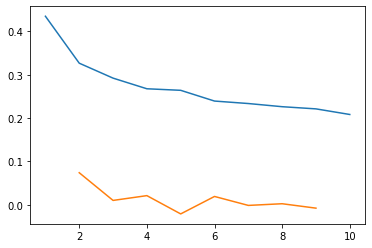

clusters: 2


In [92]:
# determine optimal number of clusters via the elbow method
import matplotlib.pyplot as plt

last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

In [93]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit_transform(X)

In [94]:
from sklearn.cluster import KMeans # import k-means

kclusters = 2 # set number of clusters

# create a new dataframe and drop the City column
armonk_mean_freq_clustering = armonk_mean_freq.drop('City', 1)

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0).fit(X) # k-means++ intelligently  
                                                                                                         # selects starter cluster centers

# check the cluster labels/assignments for each row
kmeans.labels_[0:59] 

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [95]:
# add clustering labels to city_venues_sorted dataframe
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# create a new dataframe containing the same data as all_nearby_highpop
city_clusters = all_nearby_highpop

# merge all_nearby_highpop (now city_clusters - see above line) and city_venues_sorted dataframes into one -> city_clusters dataframe
# do so to have latitude and longitude values again
city_clusters = city_clusters.join(city_venues_sorted.set_index('City'), on='City, State')

city_clusters.head(5)

,County_x,County_y,Pop2010,"City, State",Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Westchester,Westchester,4330.0,"Armonk, NY",41.12188,-73.70870,0,American Restaurant,Park,Italian Restaurant,Indian Restaurant,Mexican Restaurant,Supermarket,Gastropub,Gas Station,Sporting Goods Shop,Spa
1,Essex,Essex,35926.0,"Belleville, NJ",40.79546,-74.14925,0,Pizza Place,Italian Restaurant,Sandwich Place,Martial Arts Dojo,Gym,Chinese Restaurant,Pharmacy,Convenience Store,Shopping Plaza,Clothing Store
2,Bergen,Bergen,26652.0,"Bergenfield, NJ",40.93480,-73.99547,0,Pizza Place,Italian Restaurant,Dance Studio,Sandwich Place,Bagel Shop,Fast Food Restaurant,Bar,BBQ Joint,Convenience Store,Pharmacy
3,Essex,Essex,47315.0,"Bloomfield, NJ",40.79191,-74.19575,0,Diner,Bank,Gas Station,Donut Shop,Ice Cream Shop,Shoe Store,Market,Steakhouse,Martial Arts Dojo,Southern / Soul Food Restaurant
4,Fairfield,Fairfield County,144229.0,"Bridgeport, CT",41.18213,-73.19064,0,Donut Shop,Juice Bar,Lawyer,Italian Restaurant,Chinese Restaurant,Café,Spanish Restaurant,Concert Hall,Plaza,Latin American Restaurant


In [96]:
city_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)

In [97]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[41.12188, -73.70870], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_clusters['Latitude'], city_clusters['Longitude'], city_clusters['City, State'], city_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine each cluster more in depth

Investigate the most common venue types within each cluster of cities, and determine any patterns or trends across these clusters.

##### Cluster 0

In [98]:
cluster_0_cities = city_clusters.loc[city_clusters['Cluster Labels'] == 0, city_clusters.columns[[3] + list(range(6, city_clusters.shape[1]))]]
cluster_0_cities

,"City, State",Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armonk, NY",0,American Restaurant,Park,Italian Restaurant,Indian Restaurant,Mexican Restaurant,Supermarket,Gastropub,Gas Station,Sporting Goods Shop,Spa
1,"Belleville, NJ",0,Pizza Place,Italian Restaurant,Sandwich Place,Martial Arts Dojo,Gym,Chinese Restaurant,Pharmacy,Convenience Store,Shopping Plaza,Clothing Store
2,"Bergenfield, NJ",0,Pizza Place,Italian Restaurant,Dance Studio,Sandwich Place,Bagel Shop,Fast Food Restaurant,Bar,BBQ Joint,Convenience Store,Pharmacy
3,"Bloomfield, NJ",0,Diner,Bank,Gas Station,Donut Shop,Ice Cream Shop,Shoe Store,Market,Steakhouse,Martial Arts Dojo,Southern / Soul Food Restaurant
4,"Bridgeport, CT",0,Donut Shop,Juice Bar,Lawyer,Italian Restaurant,Chinese Restaurant,Café,Spanish Restaurant,Concert Hall,Plaza,Latin American Restaurant
5,"Carmel, NY",0,Italian Restaurant,Diner,Lake,Mexican Restaurant,Tea Room,Sandwich Place,Thai Restaurant,Bank,Bagel Shop,Trail
7,"Clifton, NJ",0,Pizza Place,Liquor Store,Pharmacy,Bank,Deli / Bodega,Rental Car Location,Flower Shop,Shopping Mall,Gym / Fitness Center,Bar
10,"East Orange, NJ",0,American Restaurant,Donut Shop,Discount Store,Chinese Restaurant,Liquor Store,Bus Stop,Restaurant,Caribbean Restaurant,Pizza Place,Food
11,"Eastchester, NY",0,Pharmacy,Pizza Place,Italian Restaurant,Pub,Bar,Hardware Store,Martial Arts Dojo,Chinese Restaurant,Sandwich Place,American Restaurant
12,"Englewood, NJ",0,Mexican Restaurant,Pizza Place,Japanese Restaurant,Bank,Gym,Italian Restaurant,Thai Restaurant,Middle Eastern Restaurant,Deli / Bodega,Optical Shop


In [99]:
cluster_0_cities.shape

(40, 12)

In [100]:
cluster_0_cities['1st Most Common Venue'].value_counts()

Pizza Place                  9
American Restaurant          6
Italian Restaurant           3
Pharmacy                     3
Mexican Restaurant           2
Fast Food Restaurant         2
Bakery                       2
Asian Restaurant             1
Deli / Bodega                1
Restaurant                   1
Golf Course                  1
Business Service             1
Bank                         1
Latin American Restaurant    1
Optical Shop                 1
Bar                          1
Diner                        1
Gym                          1
Donut Shop                   1
Lounge                       1
Name: 1st Most Common Venue, dtype: int64

In [101]:
cluster_0_cities['2nd Most Common Venue'].value_counts()

Pizza Place                  8
Italian Restaurant           5
Bank                         4
Latin American Restaurant    3
Fast Food Restaurant         2
Ice Cream Shop               2
Pharmacy                     2
Donut Shop                   1
Jewelry Store                1
American Restaurant          1
Chinese Restaurant           1
Park                         1
Miscellaneous Shop           1
Café                         1
Cosmetics Shop               1
Diner                        1
Deli / Bodega                1
Japanese Restaurant          1
Liquor Store                 1
Juice Bar                    1
Spanish Restaurant           1
Name: 2nd Most Common Venue, dtype: int64

In [102]:
cluster_0_cities['3rd Most Common Venue'].value_counts()

Pizza Place               4
Donut Shop                3
Chinese Restaurant        3
Pharmacy                  3
Beach                     2
Sandwich Place            2
Bagel Shop                2
Fast Food Restaurant      2
Italian Restaurant        2
Cuban Restaurant          1
Gas Station               1
American Restaurant       1
Gym / Fitness Center      1
Furniture / Home Store    1
Japanese Restaurant       1
Lawyer                    1
Lake                      1
Print Shop                1
Dance Studio              1
Discount Store            1
Diner                     1
Ice Cream Shop            1
Convenience Store         1
Mobile Phone Shop         1
Gym                       1
Deli / Bodega             1
Name: 3rd Most Common Venue, dtype: int64

##### Cluster 1

In [103]:
cluster_1_cities = city_clusters.loc[city_clusters['Cluster Labels'] == 1, city_clusters.columns[[3] + list(range(6, city_clusters.shape[1]))]]
cluster_1_cities

,"City, State",Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Cliffside Park, NJ",1,Turkish Restaurant,Spa,Mediterranean Restaurant,Grocery Store,Pizza Place,Chinese Restaurant,Sushi Restaurant,Café,Middle Eastern Restaurant,Mexican Restaurant
8,"Danbury, CT",1,Pizza Place,Bakery,Latin American Restaurant,Brazilian Restaurant,Gym / Fitness Center,Bank,Grocery Store,Mexican Restaurant,Pharmacy,Check Cashing Service
9,"Darien, CT",1,Pizza Place,Deli / Bodega,Italian Restaurant,Mexican Restaurant,Sandwich Place,Burger Joint,Coffee Shop,Sporting Goods Shop,Donut Shop,Gas Station
16,"Fort Lee, NJ",1,Korean Restaurant,Asian Restaurant,Japanese Restaurant,Bakery,Café,Bank,Sandwich Place,Rental Car Location,Mobile Phone Shop,Spa
18,"Greenwich, CT",1,Italian Restaurant,Clothing Store,Bank,Coffee Shop,Women's Store,Gym / Fitness Center,French Restaurant,Sushi Restaurant,Café,Supermarket
23,"Hoboken, NJ",1,Bakery,Gym / Fitness Center,Park,Coffee Shop,American Restaurant,Pizza Place,Cuban Restaurant,Pub,Sushi Restaurant,Smoke Shop
24,"Huntington, NY",1,Bar,Italian Restaurant,Pizza Place,Mexican Restaurant,Ice Cream Shop,Bank,Bakery,Deli / Bodega,Grocery Store,New American Restaurant
25,"Jersey City, NJ",1,American Restaurant,Coffee Shop,Café,Pizza Place,Taco Place,Restaurant,Gym / Fitness Center,Grocery Store,Beer Garden,Japanese Restaurant
30,"Mamaroneck, NY",1,Italian Restaurant,American Restaurant,Mexican Restaurant,Pizza Place,Bank,Donut Shop,Asian Restaurant,Baseball Field,Bakery,BBQ Joint
32,"Montclair, NJ",1,Café,Italian Restaurant,Bakery,Spa,Gym,Yoga Studio,Ice Cream Shop,Juice Bar,Pizza Place,Seafood Restaurant


In [104]:
cluster_1_cities.shape

(20, 12)

In [105]:
cluster_1_cities['1st Most Common Venue'].value_counts()

Italian Restaurant     4
Pizza Place            3
Bakery                 2
American Restaurant    2
Harbor / Marina        1
Korean Restaurant      1
Clothing Store         1
Sushi Restaurant       1
Turkish Restaurant     1
BBQ Joint              1
Café                   1
Bank                   1
Bar                    1
Name: 1st Most Common Venue, dtype: int64

In [106]:
cluster_1_cities['2nd Most Common Venue'].value_counts()

American Restaurant        4
Italian Restaurant         2
Bank                       2
Asian Restaurant           1
Clothing Store             1
Pub                        1
Bakery                     1
Coffee Shop                1
Deli / Bodega              1
Pizza Place                1
New American Restaurant    1
Spa                        1
Boat or Ferry              1
Ice Cream Shop             1
Gym / Fitness Center       1
Name: 2nd Most Common Venue, dtype: int64

In [107]:
cluster_1_cities['3rd Most Common Venue'].value_counts()

Italian Restaurant           3
Bakery                       2
Bank                         2
Mexican Restaurant           1
Indian Restaurant            1
Women's Store                1
Mediterranean Restaurant     1
Japanese Restaurant          1
Pizza Place                  1
Gourmet Shop                 1
New American Restaurant      1
Business Service             1
Café                         1
Park                         1
Latin American Restaurant    1
Convenience Store            1
Name: 3rd Most Common Venue, dtype: int64

## Results and Discussion <a name="results"></a>

Overall, it appears k-Means clustering did not provide much insight in grouping cities together. Looking at the value_counts data of each cluster, cities within both clusters tend to have a high number of pizza places, Italian restaurants, and American restaurants nearby. Although these clustered cities do not dramatically differ in their most common venues, the clusters do appear to have been intelligently made in a location-sense.  

The map showing the clusters appears to group cities along shorelines into cluster 1, and cities more inland and in congested areas to cluster 0. Even though during the clustering process only the dataframe with the most frequent venue category types (which did *not* contain location data) was used, it seems that k-Means was somehow able to cluster similar cities, albeit location-wise, together.

Based on these results, it is recommended that data scientists who prefer to eat out (especially Italian or American food) and appreciate more populated areas look into the cities around IBM's headquarters further. If neither fast food nor city-like life suit upcoming data scientists, it is recommended to consider other work locales while conducting additional research.

## Conclusion <a name="conclusion"></a>

This project examined cities - with a population of 20,000 or greater as of 2010, and within a 35-mile commute of IBM's headquarters - and their most common nearby venue types in the hope of determining optimal locations for upcoming data scientists to live. Although it was ultimately determined most of these cities were frequented by similar fast food eateries, the use of k-Means clustering provided a spatial-based grouping that may still prove beneficial to data scientists planning to reside near IBM's headquarters.  

These data scientists will have the final say on where they choose to live, but with the support of this project, they can have an easier time deciding: based on location proximity, population, and nearby common venue types. Of course, there are more factors to consider than these when deciding upon a new hometown, but this project can help reduce the time spent to make a decision.

## Acknowledgements <a name="acknowledgements"></a>

Several sources were utilized for assistance with this project. Although all of them cannot be listed, the most-used ones are mentioned below:

* Stack Overflow
 * Thank you to the various pages consulted on Stack Overflow for inspiration when I inevitably hit another wall
* IBM's Data Science Professional Certificate Courses
 * Thank you to this program and all I have learned from it
* https://www.freemaptools.com/find-zip-codes-inside-radius.htm
 * Thank you to FreeMapTools for providing the base of the means of data for this project
* https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/
 * Thank you to this page for assistance in merging and joining dataframes
* https://blog.floydhub.com/introduction-to-k-means-clustering-in-python-with-scikit-learn/
 * Thank you to this article for the help in better understanding k-Means
* https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
 * Thank you to this site for helping break down KElbowVisualizer code
* https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
 * Thank you to this article for the help in better understanding hierarchical clustering and also the elbow method

---

Notebook created by Paige Larsen.